
# Applying Temporal Convonotional Networks to the Virtual Flow Metering Problem 

## Author: Ridha Alkhabaz 

### Imports:

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# for tcn applications
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, RepeatVector
from tensorflow.keras.preprocessing import sequence
from tcn import TCN, compiled_tcn
import tensorflow as tf
import os
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/ElectricDemandForecasting-DL/src/")
from models import tcn
# for data configurations
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from datetime import timedelta
from pandas import read_csv
from pandas import datetime
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime as dttm

### Data configuration and Reading:

#### First: Riser data:

##### Reading the data and formating:

In [3]:
# Convert the sequence of seconds into datetime array
def parser(x):
    now_seconds = 0
    y = x.astype(np.float) + now_seconds
    z = pd.to_datetime(y, unit='s')
    return z

In [4]:
# Read the data from fname and eventually plot them
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Resample the data using a uniform timestep
    datats = datats.resample('S').mean()
    datats = datats.interpolate(method='linear')
    # Convert data to numpy array
    data = datats.reset_index().values

    
    # Replace timestamps with seconds
    time_sec = array([data[i, 0].timestamp() for i in range(len(data))])
    data = np.c_[time_sec, data[:, 1:]]

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    scaler.scale_[0] = 1    # Do not normalize time

    # Apply the same normalization to all pressure readings
    pind = list(range(1, 8))  # Indices of pressure readings
    pmin = scaler.data_min_[pind].min()
    pmax = scaler.data_max_[pind].max()
    scaler.scale_[pind] = ((scaler.feature_range[1] - scaler.feature_range[0]) / (pmax - pmin))
    scaler.min_[pind] = scaler.feature_range[0] - pmin * scaler.scale_[pind]

    data = scaler.transform(data)

    return data, scaler

##### Sliding window technique (Data configuration):

In [5]:
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
data_riser, _= read_data('riser_pq_uni.csv')
df_riser = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(m3/day)', 'liquid(m3/day)' ], data_riser.T)))
### previous readings for univariate model 
dt_gas_riser = np.array(df_riser['gas(m3/day)'])
dt_liquid_riser = np.array(df_riser['liquid(m3/day)'])
### gas and liquid dataframe
df_gas_riser = df_riser.drop('liquid(m3/day)', axis=1)
df_gas_riser = df_gas_riser.set_index('ds')
df_liquid_riser = df_riser.drop('gas(m3/day)', axis=1)
df_liquid_riser = df_liquid_riser.set_index('ds')

###### Some visualization for the data:

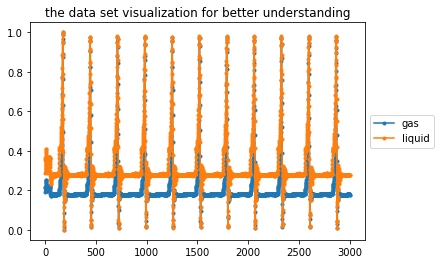

In [6]:
df_riser = df_riser.reset_index()
fig,ax = plt.subplots()
ax.set_title('the data set visualization for better understanding')
ax.plot(df_riser['ds'], df_riser['gas(m3/day)'], marker=".", label='gas')
ax.plot(df_riser['ds'], df_riser['liquid(m3/day)'], marker=".", label='liquid')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
df_riser = df_riser.set_index('ds')

##### Hyperparameters for the model:

In [7]:
# Model Hyperparemeters (general hyperparameters)
FORECAST_HORIZON = 5 #secs 
PAST_HISTORY = 300
BATCH_SIZE = 64
EPOCHS = 100

#### GAS (models)
##### Univariate Model:

In [8]:
##  gas (univariate)
# larger tcn layer and larger FCN layer 
INPUT_DIMSION = 1


model_gas_uni = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  
        Dense(FORECAST_HORIZON) 
    ]
)

model_gas_uni.summary()
model_gas_uni.compile('adam', 'mse')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 64)                136256    
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [9]:
## gas (multivariate)
INPUT_DIMSION = 8 

model_gas_mult = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  
        Dense(FORECAST_HORIZON) 
    ]
)

model_gas_mult.summary()
model_gas_mult.compile('adam', 'mse')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 64)                138048    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 138,373
Trainable params: 138,373
Non-trainable params: 0
_________________________________________________________________


In [10]:
## liquid (univariate)
INPUT_DIMSION = 1

model_liq_uni = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  
        Dense(FORECAST_HORIZON) 
    ]
)

model_liq_uni.summary()
model_liq_uni.compile('adam', 'mse')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_2 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [11]:
## liquid  (multivariate)
INPUT_DIMSION =8


model_liquid_mult = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  
        Dense(FORECAST_HORIZON) 
    ]
)

model_liquid_mult.summary()
model_liquid_mult.compile('adam', 'mse')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_3 (TCN)                  (None, 64)                138048    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 138,373
Trainable params: 138,373
Non-trainable params: 0
_________________________________________________________________


#### Data configuration for training and testing:

In [12]:
def univariate_data(tseries, start_index, end_index, history_size, forecast_horizon, step=1, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    for i in range(start_index, end_index - forecast_horizon + 1):
        indices = range(i - history_size, i, step)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(tseries[indices], (history_size, 1)))

        if single_step:
            labels.append(tseries[i + forecast_horizon])
        else:
            labels.append(tseries[i:i + forecast_horizon])

    return np.array(data), np.array(labels)
def multivariate_data(tseries, start_index, end_index, history_size, forecast_horizon):
    data = []
    labels = []
    for i in range(start_index, end_index -history_size +1, forecast_horizon):
        end = i+history_size
        data.append(tseries[i:end, :])
        labels.append(tseries[end:end+forecast_horizon, 7:])
    return np.array(data), np.array(labels)

def configure(data, params = [0, 1500, 2500, 3000], multi = False):
    if multi:
        x_mult, y_mult= multivariate_data(np.array(data), params[0], params[1], PAST_HISTORY, FORECAST_HORIZON)
        valX_mult , valY_mult = multivariate_data(np.array(data), params[1], params[2], PAST_HISTORY, FORECAST_HORIZON)
        testX_mult, testY_mult = multivariate_data(np.array(data), params[2], params[3]-1, PAST_HISTORY, FORECAST_HORIZON)
        # to avoid combatibility issues
        x_mult = x_mult.astype(np.float32)
        y_mult = y_mult.astype(np.float32)
        valX_mult = valX_mult.astype(np.float32)
        valY_mult = valY_mult.astype(np.float32)
        testX_mult = testX_mult.astype(np.float32)
        testY_mult = testY_mult.astype(np.float32)
        # to build data set
        train_data_mult = tf.data.Dataset.from_tensor_slices((x_mult, y_mult)).cache().batch(BATCH_SIZE).repeat()
        val_data_mult = tf.data.Dataset.from_tensor_slices((valX_mult, valY_mult)).batch(BATCH_SIZE).repeat()
        return train_data_mult, val_data_mult, testX_mult, testY_mult
    # for univariate 
    x_uni, y_uni = univariate_data(np.array(data), params[0], params[1], PAST_HISTORY, FORECAST_HORIZON, single_step=False)
    valX_uni , valY_uni = univariate_data(np.array(data), params[1], params[2], PAST_HISTORY, FORECAST_HORIZON, step=1, single_step=False)
    testX_uni, testY_uni = univariate_data(np.array(data),params[2], params[3], PAST_HISTORY, FORECAST_HORIZON, step=1, single_step=False)
    # to avoid combatibality issues
    x_uni = x_uni.astype(np.float32)
    y_uni = y_uni.astype(np.float32)
    valX_uni = valX_uni.astype(np.float32)
    valY_uni = valY_uni.astype(np.float32)
    testX_uni = testX_uni.astype(np.float32)
    testY_uni = testY_uni.astype(np.float32)
    # to build data set 
    train_data_uni = tf.data.Dataset.from_tensor_slices((x_uni, y_uni)).cache().batch(BATCH_SIZE).repeat()
    val_data_uni = tf.data.Dataset.from_tensor_slices((valX_uni, valY_uni)).batch(BATCH_SIZE).repeat()
    return train_data_uni, val_data_uni, testX_uni, testY_uni

In [13]:
## gas (uni & multi)
gas_uni_train, gas_uni_val, gas_uni_testX, gas_uni_testY = configure(dt_gas_riser, params = [0, 1500, 2500, 3000], multi = False)
gas_mult_train, gas_mult_val, gas_mult_testX, gas_mult_testY = configure(df_gas_riser, params = [0, 1500, 2500, 3000], multi = True)
##liquid (uni & multi)
liq_uni_train, liq_uni_val, liq_uni_testX, liq_uni_testY= configure(dt_liquid_riser, params = [0, 1500, 2500, 3000], multi = False)
liq_mult_train, liq_mult_val, liq_mult_testX, liq_mult_testY = configure(df_liquid_riser, params = [0, 1500, 2500, 3000], multi = True)

In [15]:
##gas 
## univariate 
evaluation_gas_interval = 10
history_gas_uni = model_gas_uni.fit(gas_uni_train, epochs=100, steps_per_epoch=evaluation_gas_interval\
                                    , validation_data=gas_uni_val, validation_steps=evaluation_gas_interval)

Epoch 1/100
10/10 [==============================] - 8s 793ms/step - loss: 1.2517 - val_loss: 0.4681
Epoch 2/100
10/10 [==============================] - 6s 615ms/step - loss: 0.2745 - val_loss: 0.1710
Epoch 3/100
10/10 [==============================] - 5s 507ms/step - loss: 0.1125 - val_loss: 0.0711
Epoch 4/100
10/10 [==============================] - 5s 537ms/step - loss: 0.0430 - val_loss: 0.0441
Epoch 5/100
10/10 [==============================] - 6s 567ms/step - loss: 0.0361 - val_loss: 0.0244
Epoch 6/100
10/10 [==============================] - 5s 553ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 7/100
10/10 [==============================] - 7s 671ms/step - loss: 0.0169 - val_loss: 0.0133
Epoch 8/100
10/10 [==============================] - 6s 664ms/step - loss: 0.0128 - val_loss: 0.0118
Epoch 9/100
10/10 [==============================] - 6s 633ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 10/100
10/10 [==============================] - 6s 636ms/step - loss: 0.0109 - val_lo

10/10 [==============================] - 6s 626ms/step - loss: 9.9107e-04 - val_loss: 7.7187e-04
Epoch 81/100
10/10 [==============================] - 6s 661ms/step - loss: 9.5706e-04 - val_loss: 6.5557e-04
Epoch 82/100
10/10 [==============================] - 6s 655ms/step - loss: 6.2649e-04 - val_loss: 6.4863e-04
Epoch 83/100
10/10 [==============================] - 7s 687ms/step - loss: 6.4234e-04 - val_loss: 5.2440e-04
Epoch 84/100
10/10 [==============================] - 6s 663ms/step - loss: 4.6657e-04 - val_loss: 4.9492e-04
Epoch 85/100
10/10 [==============================] - 6s 642ms/step - loss: 4.8181e-04 - val_loss: 4.7506e-04
Epoch 86/100
10/10 [==============================] - 6s 644ms/step - loss: 4.2695e-04 - val_loss: 5.0019e-04
Epoch 87/100
10/10 [==============================] - 6s 642ms/step - loss: 4.8872e-04 - val_loss: 4.3573e-04
Epoch 88/100
10/10 [==============================] - 6s 588ms/step - loss: 3.4299e-04 - val_loss: 4.2725e-04
Epoch 89/100
10/10 [===

In [16]:
## mutlivariate 
evaluation_interval = 10
history_gas_mult = model_gas_mult.fit(gas_mult_train, epochs=100, steps_per_epoch=evaluation_gas_interval,\
                                      validation_data=gas_mult_val, validation_steps=evaluation_gas_interval)

Epoch 1/100
10/10 [==============================] - 13s 864ms/step - loss: 81.4587 - val_loss: 0.5421
Epoch 2/100
10/10 [==============================] - 9s 959ms/step - loss: 0.6352 - val_loss: 0.4231
Epoch 3/100
10/10 [==============================] - 7s 717ms/step - loss: 0.2710 - val_loss: 0.1499
Epoch 4/100
10/10 [==============================] - 7s 713ms/step - loss: 0.1312 - val_loss: 0.0806
Epoch 5/100
10/10 [==============================] - 9s 905ms/step - loss: 0.0717 - val_loss: 0.0649
Epoch 6/100
10/10 [==============================] - 7s 700ms/step - loss: 0.0586 - val_loss: 0.0494
Epoch 7/100
10/10 [==============================] - 7s 723ms/step - loss: 0.0427 - val_loss: 0.0396
Epoch 8/100
10/10 [==============================] - 7s 716ms/step - loss: 0.0367 - val_loss: 0.0330
Epoch 9/100
10/10 [==============================] - 7s 703ms/step - loss: 0.0298 - val_loss: 0.0292
Epoch 10/100
10/10 [==============================] - 7s 750ms/step - loss: 0.0281 - val_

10/10 [==============================] - 5s 530ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 82/100
10/10 [==============================] - 5s 518ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 83/100
10/10 [==============================] - 5s 554ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 84/100
10/10 [==============================] - 5s 559ms/step - loss: 0.0052 - val_loss: 0.0226
Epoch 85/100
10/10 [==============================] - 5s 535ms/step - loss: 0.0113 - val_loss: 0.0034
Epoch 86/100
10/10 [==============================] - 5s 530ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 87/100
10/10 [==============================] - 6s 582ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 88/100
10/10 [==============================] - 7s 695ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 89/100
10/10 [==============================] - 7s 704ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 90/100
10/10 [==============================] - 7s 711ms/step - loss: 0.0027 - val_loss: 

In [17]:
##liquid 
## univariate 
evaluation_interval = 10
history_liq_uni = model_liq_uni.fit(liq_uni_train, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=liq_uni_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 12s 704ms/step - loss: 6.4870 - val_loss: 0.4821
Epoch 2/100
10/10 [==============================] - 5s 541ms/step - loss: 0.5191 - val_loss: 0.2627
Epoch 3/100
10/10 [==============================] - 5s 561ms/step - loss: 0.2307 - val_loss: 0.1256
Epoch 4/100
10/10 [==============================] - 6s 558ms/step - loss: 0.1092 - val_loss: 0.0713
Epoch 5/100
10/10 [==============================] - 6s 579ms/step - loss: 0.0847 - val_loss: 0.0420
Epoch 6/100
10/10 [==============================] - 5s 550ms/step - loss: 0.0332 - val_loss: 0.0302
Epoch 7/100
10/10 [==============================] - 5s 562ms/step - loss: 0.0258 - val_loss: 0.0219
Epoch 8/100
10/10 [==============================] - 5s 540ms/step - loss: 0.0183 - val_loss: 0.0170
Epoch 9/100
10/10 [==============================] - 5s 555ms/step - loss: 0.0155 - val_loss: 0.0147
Epoch 10/100
10/10 [==============================] - 5s 561ms/step - loss: 0.0148 - val_l

Epoch 81/100
10/10 [==============================] - 6s 646ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 82/100
10/10 [==============================] - 6s 580ms/step - loss: 0.0013 - val_loss: 9.5480e-04
Epoch 83/100
10/10 [==============================] - 5s 555ms/step - loss: 0.0011 - val_loss: 6.8217e-04
Epoch 84/100
10/10 [==============================] - 5s 530ms/step - loss: 8.6203e-04 - val_loss: 8.3393e-04
Epoch 85/100
10/10 [==============================] - 6s 567ms/step - loss: 8.9470e-04 - val_loss: 7.1279e-04
Epoch 86/100
10/10 [==============================] - 5s 543ms/step - loss: 8.1037e-04 - val_loss: 7.8805e-04
Epoch 87/100
10/10 [==============================] - 5s 556ms/step - loss: 7.7090e-04 - val_loss: 6.8869e-04
Epoch 88/100
10/10 [==============================] - 5s 541ms/step - loss: 5.3555e-04 - val_loss: 6.9734e-04
Epoch 89/100
10/10 [==============================] - 5s 554ms/step - loss: 7.1418e-04 - val_loss: 5.9362e-04
Epoch 90/100
10/10 [======

In [18]:
## multivariate 
evaluation_interval = 10
history_liquid_mult = model_liquid_mult.fit(liq_mult_train, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=liq_mult_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 11s 704ms/step - loss: 85.7303 - val_loss: 0.8908
Epoch 2/100
10/10 [==============================] - 6s 642ms/step - loss: 0.9684 - val_loss: 0.3709
Epoch 3/100
10/10 [==============================] - 6s 649ms/step - loss: 0.2388 - val_loss: 0.1160
Epoch 4/100
10/10 [==============================] - 6s 589ms/step - loss: 0.1046 - val_loss: 0.0625
Epoch 5/100
10/10 [==============================] - 6s 572ms/step - loss: 0.0528 - val_loss: 0.0383
Epoch 6/100
10/10 [==============================] - 5s 509ms/step - loss: 0.0351 - val_loss: 0.0258
Epoch 7/100
10/10 [==============================] - 5s 527ms/step - loss: 0.0244 - val_loss: 0.0211
Epoch 8/100
10/10 [==============================] - 5s 485ms/step - loss: 0.0211 - val_loss: 0.0183
Epoch 9/100
10/10 [==============================] - 5s 503ms/step - loss: 0.0175 - val_loss: 0.0159
Epoch 10/100
10/10 [==============================] - 5s 499ms/step - loss: 0.0161 - val_

Epoch 80/100
10/10 [==============================] - 5s 483ms/step - loss: 4.4836e-04 - val_loss: 8.5785e-04
Epoch 81/100
10/10 [==============================] - 5s 498ms/step - loss: 4.3241e-04 - val_loss: 8.4061e-04
Epoch 82/100
10/10 [==============================] - 5s 488ms/step - loss: 4.3424e-04 - val_loss: 8.5472e-04
Epoch 83/100
10/10 [==============================] - 6s 580ms/step - loss: 4.2436e-04 - val_loss: 8.3665e-04
Epoch 84/100
10/10 [==============================] - 6s 640ms/step - loss: 4.2974e-04 - val_loss: 8.4901e-04
Epoch 85/100
10/10 [==============================] - 6s 638ms/step - loss: 4.2170e-04 - val_loss: 8.3596e-04
Epoch 86/100
10/10 [==============================] - 6s 580ms/step - loss: 4.2919e-04 - val_loss: 8.5795e-04
Epoch 87/100
10/10 [==============================] - 6s 634ms/step - loss: 4.2366e-04 - val_loss: 8.4248e-04
Epoch 88/100
10/10 [==============================] - 9s 863ms/step - loss: 4.3305e-04 - val_loss: 8.6669e-04
Epoch 89/1

In [19]:
def mse(real, pred):
    return mean_squared_error(real, pred)


In [20]:
[mse(model_gas_uni.predict(gas_uni_testX).flatten(), gas_uni_testY.flatten()),\
 mse(model_gas_mult.predict(gas_mult_testX).flatten(), gas_mult_testY.flatten()),\
 mse(model_liq_uni.predict(liq_uni_testX).flatten(), liq_uni_testY.flatten()),\
 mse(model_liquid_mult.predict(liq_mult_testX).flatten(), liq_mult_testY.flatten())]

[0.000447502, 0.0006744899, 0.005413877, 0.00041600317]

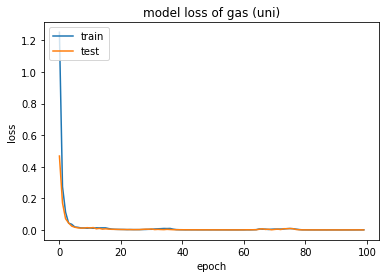

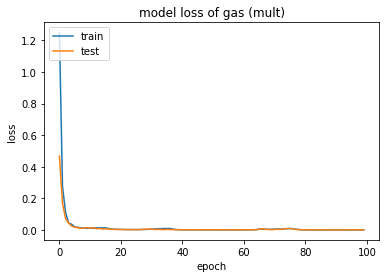

In [21]:
## GAS 
# summarize history for loss
plt.plot(history_gas_uni.history['loss'])
plt.plot(history_gas_uni.history['val_loss'])
plt.title('model loss of gas (uni)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_gas_uni.history['loss'])
plt.plot(history_gas_uni.history['val_loss'])
plt.title('model loss of gas (mult)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

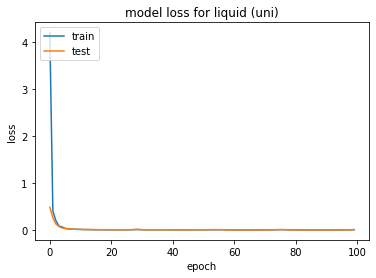

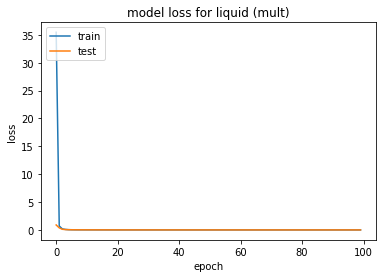

In [22]:
## Liquid 
plt.plot(history_liq_uni.history['loss'])
plt.plot(history_liq_uni.history['val_loss'])
plt.title('model loss for liquid (uni)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_liquid_mult.history['loss'])
plt.plot(history_liquid_mult.history['val_loss'])
plt.title('model loss for liquid (mult)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
## gas testing data set visualization
### univariate 
real_gas_uni = gas_uni_testY.flatten()
pred_gas_uni = model_gas_uni.predict(gas_uni_testX).flatten()
df_plot_gas_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni, real_gas_uni]))))
df_plot_gas_uni['ds']=range(0,len(real_gas_uni))
### multivariate 
real_gas_mult = gas_mult_testY.flatten()
pred_gas_mult = model_gas_mult.predict(gas_mult_testX).flatten()
df_plot_gas_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult, real_gas_mult]))))
df_plot_gas_mult['ds']=range(0,len(real_gas_mult))
##liquid
## univariate
real_liq_uni = liq_uni_testY.flatten()
pred_liq_uni = model_liq_uni.predict(liq_uni_testX).flatten()
df_plot_liq_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni, real_gas_uni]))))
df_plot_liq_uni['ds']=range(0,len(real_liq_uni))
## multivariate 
real_liq_mult = liq_mult_testY.flatten()
pred_liq_mult = model_liquid_mult.predict(liq_mult_testX).flatten()
df_plot_liq_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_liq_mult, real_liq_mult]))))
df_plot_liq_mult['ds']=range(0,len(real_liq_mult))

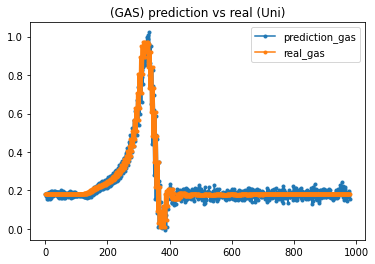

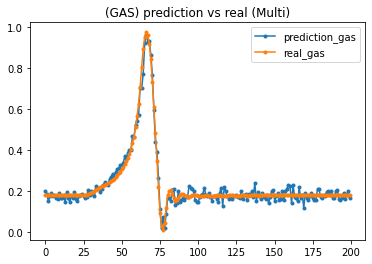

In [24]:
### gas before noise, removed data and spikes 
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real (Uni)')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real (Multi)')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()

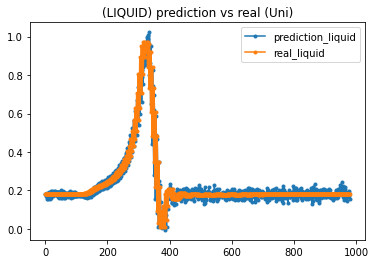

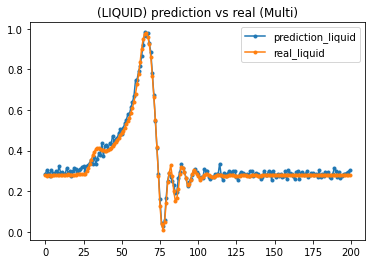

In [25]:
### liquid before noise, removed data and spikes 
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(LIQUID) prediction vs real (Uni)')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['prediction'].iloc[start:end], marker=".", label='prediction_liquid')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['real'].iloc[start:end], marker=".", label='real_liquid')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(LIQUID) prediction vs real (Multi)')
ax.plot(df_plot_liq_mult['ds'].iloc[start:end], df_plot_liq_mult['prediction'].iloc[start:end], marker=".", label='prediction_liquid')
ax.plot(df_plot_liq_mult['ds'].iloc[start:end], df_plot_liq_mult['real'].iloc[start:end], marker=".", label='real_liquid')
ax.legend()

##### The well dataset 

In [26]:
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, dayfirst=True, parse_dates=[0], index_col=0, squeeze=True)  # , date_parser=parser

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Convert data to numpy array
    data = datats.reset_index().values

    # Split data into flow periods, and resample each flow period using a uniform timestep
    dt = np.ediff1d(data[:, 0])
    fpbreak = dttm.timedelta(hours=1)  # Minimal break between flow periods
    dt = dt - fpbreak
    ind = np.where(dt - fpbreak > pd.Timedelta(0))[0]
    ind = np.r_[ind, len(data)-1]

    Nfp = len(ind)  # Number of flow periods
    fp = ['None'] * Nfp
    n0 = 0
    n1 = ind[0]+1
    for n in range(Nfp):
        # Resample each flow period separately
        fpts = datats[n0:n1].resample('T').mean()
        fpts = fpts.interpolate(method='linear')
        # Save the resampled flow period to a list of numpy arrays
        fp[n] = fpts.reset_index().values
        #fp[n] = data[n0:n1,:]
        n0 = n1
        if n+1 < Nfp:
            n1 = ind[n+1] + 1

    # Get the normalization parameters for all data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data[:,1:]) # Exclude Datetime from normalization

    # Normalize every flow period
    for n in range(Nfp):
        fp[n][:,1:] = scaler.transform(fp[n][:,1:])
    return fp, headers, scaler

In [27]:
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
fp, headers, scaler = read_data('welltest.csv')
df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
for i in [1,2, 3, 4]:
    tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
    df = pd.concat([df,tmp], axis=0)
df = df.drop(['DateTime'], axis=1)
## univariate training
train_uni_oil= np.array(df['Qo (m3/day)'])
train_uni_water= np.array(df['Qw (m3/day)']) 
train_uni_gas= np.array(df['Qg (m3/day)']) 
## multivariate 
train_mult_oil = df.iloc[:, 0:3]
train_mult_water = pd.concat([df.iloc[:, 0:2], df['Qw (m3/day)']], axis=1)
train_mult_gas = pd.concat([df.iloc[:, 0:2], df['Qg (m3/day)']], axis=1)

##### Model parameters and structure:

In [29]:
# Model Hyperparemeters (general hyperparameters)
FORECAST_HORIZON = 5 #secs 
PAST_HISTORY = 300
BATCH_SIZE = 64


In [30]:
##  Oil (univariate)
INPUT_DIMSION = 1
model_oil_uni = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_oil_uni.summary()
model_oil_uni.compile('adam', 'mse')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_4 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [31]:
## multivariate 
INPUT_DIMSION = 3
model_oil_mult = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_oil_mult.summary()
model_oil_mult.compile('adam', 'mse')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_5 (TCN)                  (None, 64)                136768    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 137,093
Trainable params: 137,093
Non-trainable params: 0
_________________________________________________________________


In [32]:
##  water (univariate)
INPUT_DIMSION = 1
model_water_uni = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_water_uni.summary()
model_water_uni.compile('adam', 'mse')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_6 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [33]:
##  water (multivariate)
INPUT_DIMSION = 3
model_water_mult = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_water_mult.summary()
model_water_mult.compile('adam', 'mse')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_7 (TCN)                  (None, 64)                136768    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 137,093
Trainable params: 137,093
Non-trainable params: 0
_________________________________________________________________


In [52]:
##  gas (univariate)
INPUT_DIMSION = 1
model_gas_uni_well = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_gas_uni_well.summary()
model_gas_uni_well.compile('adam', 'mse')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_12 (TCN)                 (None, 64)                136256    
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [53]:
##  gas (multivariate)
INPUT_DIMSION = 3
model_gas_mult_well = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_gas_mult_well.summary()
model_gas_mult_well.compile('adam', 'mse')

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_13 (TCN)                 (None, 64)                136768    
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 137,093
Trainable params: 137,093
Non-trainable params: 0
_________________________________________________________________


#### Data configuration:

In [36]:
def univariate_data(tseries, start_index, end_index, history_size, forecast_horizon, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    for i in range(start_index, end_index - forecast_horizon + 1, forecast_horizon):
        end = i+history_size
        if len(tseries[i:end]) < history_size:
            break
        data.append(tseries[i:end].reshape(history_size, 1))
        labels.append(tseries[i:i + forecast_horizon])

    return np.array(data), np.array(labels)
def multivariate_data(tseries, start_index, end_index, history_size, forecast_horizon):
    data = []
    labels = []
    for i in range(start_index, end_index -history_size, forecast_horizon):
        end = i+history_size
        if len(tseries[end:end+forecast_horizon, 2:]) <5:
            break
        data.append(tseries[i:end, :])
        labels.append(tseries[end:end+forecast_horizon, 2:])
    return np.array(data), np.array(labels)

def configure(data, params = [0, 4557, 5535, 7933], multi = False):
    if multi:
        x_mult, y_mult= multivariate_data(np.array(data), params[0], params[1], PAST_HISTORY, FORECAST_HORIZON)
        valX_mult , valY_mult = multivariate_data(np.array(data), params[1], params[2], PAST_HISTORY, FORECAST_HORIZON)
        testX_mult, testY_mult = multivariate_data(np.array(data), params[2], params[3], PAST_HISTORY, FORECAST_HORIZON)
        # to avoid combatibility issues
        x_mult = x_mult.astype(np.float32)
        y_mult = y_mult.astype(np.float32)
        valX_mult = valX_mult.astype(np.float32)
        valY_mult = valY_mult.astype(np.float32)
        testX_mult = testX_mult.astype(np.float32)
        testY_mult = testY_mult.astype(np.float32)
        # to build data set
        train_data_mult = tf.data.Dataset.from_tensor_slices((x_mult, y_mult)).cache().batch(BATCH_SIZE).repeat()
        val_data_mult = tf.data.Dataset.from_tensor_slices((valX_mult, valY_mult)).batch(BATCH_SIZE).repeat()
        return train_data_mult, val_data_mult, testX_mult, testY_mult
    # for univariate 
    x_uni, y_uni = univariate_data(np.array(data), params[0], params[1], PAST_HISTORY, FORECAST_HORIZON)
    valX_uni , valY_uni = univariate_data(np.array(data), params[1], params[2], PAST_HISTORY, FORECAST_HORIZON)
    testX_uni, testY_uni = univariate_data(np.array(data),params[2], params[3], PAST_HISTORY, FORECAST_HORIZON)
    # to avoid combatibality issues
    x_uni = x_uni.astype(np.float32)
    y_uni = y_uni.astype(np.float32)
    valX_uni = valX_uni.astype(np.float32)
    valY_uni = valY_uni.astype(np.float32)
    testX_uni = testX_uni.astype(np.float32)
    testY_uni = testY_uni.astype(np.float32)
    # to build data set 
    train_data_uni = tf.data.Dataset.from_tensor_slices((x_uni, y_uni)).cache().batch(BATCH_SIZE).repeat()
    val_data_uni = tf.data.Dataset.from_tensor_slices((valX_uni, valY_uni)).batch(BATCH_SIZE).repeat()
    return train_data_uni, val_data_uni, testX_uni, testY_uni

In [47]:
## Oil
oil_uni_train, oil_uni_val, oil_uni_testX, oil_uni_testY = configure(train_uni_oil, \
                                                                     params = [0, 4557, 5535, 7934], multi = False)
oil_mult_train, oil_mult_val, oil_mult_testX, oil_mult_testY = configure(train_mult_oil,\
                                                                         params = [0, 4557, 5535, 7933], multi = True)
# Water 
water_uni_train, water_uni_val, water_uni_testX, water_uni_testY = configure(train_uni_water, \
                                                                     params = [0, 4557, 5535, 7934], multi = False)
water_mult_train, water_mult_val, water_mult_testX, water_mult_testY = configure(train_mult_water,\
                                                                         params = [0, 4557, 5535, 7933], multi = True)
# Gas
# Water 
gas_uni_train_well, gas_uni_val_well, gas_uni_testX_well, gas_uni_testY_well = configure(train_uni_gas, \
                                                                     params = [0, 4557, 5535, 7934], multi = False)
gas_mult_train_well, gas_mult_val_well, gas_mult_testX_well, gas_mult_testY_well = configure(train_mult_gas,\
                                                                         params = [0, 4557, 5535, 7933], multi = True)

In [38]:
## oil 
## univariate
evaluation_interval = 10
history_oil_uni = model_oil_uni.fit(oil_uni_train, epochs=100, steps_per_epoch=evaluation_interval, validation_data=oil_uni_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 8s 559ms/step - loss: 0.4658 - val_loss: 0.0207
Epoch 2/100
10/10 [==============================] - 5s 469ms/step - loss: 0.0409 - val_loss: 0.0282
Epoch 3/100
10/10 [==============================] - 5s 463ms/step - loss: 0.0303 - val_loss: 0.0336
Epoch 4/100
10/10 [==============================] - 5s 477ms/step - loss: 0.0293 - val_loss: 0.0088
Epoch 5/100
10/10 [==============================] - 4s 454ms/step - loss: 0.0186 - val_loss: 0.0097
Epoch 6/100
10/10 [==============================] - 5s 463ms/step - loss: 0.0103 - val_loss: 0.0154
Epoch 7/100
10/10 [==============================] - 5s 461ms/step - loss: 0.0167 - val_loss: 0.0049
Epoch 8/100
10/10 [==============================] - 5s 510ms/step - loss: 0.0061 - val_loss: 0.0070
Epoch 9/100
10/10 [==============================] - 5s 461ms/step - loss: 0.0071 - val_loss: 0.0151
Epoch 10/100
10/10 [==============================] - 5s 473ms/step - loss: 0.0063 - val_lo

10/10 [==============================] - 5s 486ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 82/100
10/10 [==============================] - 5s 464ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 83/100
10/10 [==============================] - 4s 456ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 84/100
10/10 [==============================] - 5s 493ms/step - loss: 0.0063 - val_loss: 0.0020
Epoch 85/100
10/10 [==============================] - 6s 635ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 86/100
10/10 [==============================] - 6s 597ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 87/100
10/10 [==============================] - 6s 575ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 88/100
10/10 [==============================] - 6s 617ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 89/100
10/10 [==============================] - 6s 576ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 90/100
10/10 [==============================] - 6s 601ms/step - loss: 0.0023 - val_loss: 

In [40]:
## oil 
## multivariate 0try pressure only and tempreture only 
evaluation_interval = 10
history_oil_mult = model_oil_mult.fit(oil_mult_train, epochs=100, steps_per_epoch=evaluation_interval, validation_data=oil_mult_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 13s 912ms/step - loss: 36.0344 - val_loss: 0.3783
Epoch 2/100
10/10 [==============================] - 8s 813ms/step - loss: 0.3254 - val_loss: 0.2518
Epoch 3/100
10/10 [==============================] - 6s 588ms/step - loss: 0.1800 - val_loss: 0.1675
Epoch 4/100
10/10 [==============================] - 6s 634ms/step - loss: 0.0651 - val_loss: 0.0364
Epoch 5/100
10/10 [==============================] - 6s 594ms/step - loss: 0.0243 - val_loss: 0.0344
Epoch 6/100
10/10 [==============================] - 6s 612ms/step - loss: 0.0250 - val_loss: 0.0564
Epoch 7/100
10/10 [==============================] - 6s 623ms/step - loss: 0.0387 - val_loss: 0.0061
Epoch 8/100
10/10 [==============================] - 6s 607ms/step - loss: 0.0125 - val_loss: 0.0090
Epoch 9/100
10/10 [==============================] - 5s 556ms/step - loss: 0.0103 - val_loss: 0.0387
Epoch 10/100
10/10 [==============================] - 5s 543ms/step - loss: 0.0188 - val_

10/10 [==============================] - 7s 693ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 82/100
10/10 [==============================] - 7s 685ms/step - loss: 0.0068 - val_loss: 0.0135
Epoch 83/100
10/10 [==============================] - 6s 650ms/step - loss: 0.0079 - val_loss: 0.0383
Epoch 84/100
10/10 [==============================] - 8s 793ms/step - loss: 0.0112 - val_loss: 0.0029
Epoch 85/100
10/10 [==============================] - 7s 694ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 86/100
10/10 [==============================] - 6s 619ms/step - loss: 0.0062 - val_loss: 0.0198
Epoch 87/100
10/10 [==============================] - 6s 594ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 88/100
10/10 [==============================] - 6s 638ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 89/100
10/10 [==============================] - 6s 611ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 90/100
10/10 [==============================] - 6s 596ms/step - loss: 0.0041 - val_loss: 

In [43]:
## water 
## univariate 
evaluation_interval = 10
history_water_uni = model_water_uni.fit(water_uni_train, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=water_uni_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 7s 762ms/step - loss: 0.3012 - val_loss: 0.3948
Epoch 2/100
10/10 [==============================] - 6s 645ms/step - loss: 0.2137 - val_loss: 1.4840
Epoch 3/100
10/10 [==============================] - 6s 617ms/step - loss: 0.2428 - val_loss: 0.2781
Epoch 4/100
10/10 [==============================] - 6s 634ms/step - loss: 0.0955 - val_loss: 0.1471
Epoch 5/100
10/10 [==============================] - 6s 576ms/step - loss: 0.0960 - val_loss: 0.5034
Epoch 6/100
10/10 [==============================] - 6s 570ms/step - loss: 0.1130 - val_loss: 0.5620
Epoch 7/100
10/10 [==============================] - 5s 527ms/step - loss: 0.1333 - val_loss: 0.1169
Epoch 8/100
10/10 [==============================] - 5s 550ms/step - loss: 0.0970 - val_loss: 0.0848
Epoch 9/100
10/10 [==============================] - 5s 483ms/step - loss: 0.0806 - val_loss: 0.3197
Epoch 10/100
10/10 [==============================] - 5s 469ms/step - loss: 0.0785 - val_lo

10/10 [==============================] - 7s 742ms/step - loss: 0.0128 - val_loss: 0.0170
Epoch 82/100
10/10 [==============================] - 7s 734ms/step - loss: 0.0063 - val_loss: 0.0519
Epoch 83/100
10/10 [==============================] - 6s 626ms/step - loss: 0.0139 - val_loss: 0.0207
Epoch 84/100
10/10 [==============================] - 6s 606ms/step - loss: 0.0162 - val_loss: 0.0226
Epoch 85/100
10/10 [==============================] - 6s 644ms/step - loss: 0.0114 - val_loss: 0.0431
Epoch 86/100
10/10 [==============================] - 6s 624ms/step - loss: 0.0086 - val_loss: 0.0387
Epoch 87/100
10/10 [==============================] - 6s 626ms/step - loss: 0.0142 - val_loss: 0.0213
Epoch 88/100
10/10 [==============================] - 7s 667ms/step - loss: 0.0144 - val_loss: 0.0293
Epoch 89/100
10/10 [==============================] - 6s 633ms/step - loss: 0.0056 - val_loss: 0.0263
Epoch 90/100
10/10 [==============================] - 6s 654ms/step - loss: 0.0108 - val_loss: 

In [44]:
## multivariate 
evaluation_interval = 10
history_water_mult = model_water_mult.fit(water_mult_train, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=water_mult_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 12s 727ms/step - loss: 6.3834 - val_loss: 0.9983
Epoch 2/100
10/10 [==============================] - 7s 728ms/step - loss: 0.7359 - val_loss: 2.1454
Epoch 3/100
10/10 [==============================] - 8s 739ms/step - loss: 0.4148 - val_loss: 0.6271
Epoch 4/100
10/10 [==============================] - 9s 951ms/step - loss: 0.1471 - val_loss: 0.1056
Epoch 5/100
10/10 [==============================] - 10s 990ms/step - loss: 0.1141 - val_loss: 0.6562
Epoch 6/100
10/10 [==============================] - 9s 907ms/step - loss: 0.1434 - val_loss: 0.4531
Epoch 7/100
10/10 [==============================] - 7s 712ms/step - loss: 0.0882 - val_loss: 0.0706
Epoch 8/100
10/10 [==============================] - 8s 784ms/step - loss: 0.0367 - val_loss: 0.0321
Epoch 9/100
10/10 [==============================] - 7s 745ms/step - loss: 0.0304 - val_loss: 0.2946
Epoch 10/100
10/10 [==============================] - 8s 840ms/step - loss: 0.0538 - val_

10/10 [==============================] - 5s 550ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 82/100
10/10 [==============================] - 6s 610ms/step - loss: 0.0073 - val_loss: 0.0159
Epoch 83/100
10/10 [==============================] - 6s 589ms/step - loss: 0.0081 - val_loss: 0.0194
Epoch 84/100
10/10 [==============================] - 6s 576ms/step - loss: 0.0080 - val_loss: 0.0140
Epoch 85/100
10/10 [==============================] - 6s 615ms/step - loss: 0.0097 - val_loss: 0.0058
Epoch 86/100
10/10 [==============================] - 6s 596ms/step - loss: 0.0072 - val_loss: 0.0168
Epoch 87/100
10/10 [==============================] - 6s 611ms/step - loss: 0.0076 - val_loss: 0.0239
Epoch 88/100
10/10 [==============================] - 6s 643ms/step - loss: 0.0088 - val_loss: 0.0050
Epoch 89/100
10/10 [==============================] - 6s 589ms/step - loss: 0.0086 - val_loss: 0.0195
Epoch 90/100
10/10 [==============================] - 6s 590ms/step - loss: 0.0090 - val_loss: 

In [54]:
## gas 
## univariate 
evaluation_interval = 10
history_gas_uni_well = model_gas_uni_well.fit(gas_uni_train_well, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=gas_uni_val_well, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 7s 546ms/step - loss: 1.2663 - val_loss: 1.2322
Epoch 2/100
10/10 [==============================] - 5s 477ms/step - loss: 0.6550 - val_loss: 1.2494
Epoch 3/100
10/10 [==============================] - 5s 480ms/step - loss: 0.2301 - val_loss: 0.3925
Epoch 4/100
10/10 [==============================] - 5s 500ms/step - loss: 0.1129 - val_loss: 0.0948
Epoch 5/100
10/10 [==============================] - 6s 581ms/step - loss: 0.1180 - val_loss: 0.0854
Epoch 6/100
10/10 [==============================] - 6s 606ms/step - loss: 0.0777 - val_loss: 0.3583
Epoch 7/100
10/10 [==============================] - 6s 583ms/step - loss: 0.0850 - val_loss: 0.0595
Epoch 8/100
10/10 [==============================] - 6s 629ms/step - loss: 0.0451 - val_loss: 0.0484
Epoch 9/100
10/10 [==============================] - 6s 605ms/step - loss: 0.0742 - val_loss: 0.4004
Epoch 10/100
10/10 [==============================] - 6s 599ms/step - loss: 0.0852 - val_lo

10/10 [==============================] - 7s 692ms/step - loss: 0.0190 - val_loss: 0.0217
Epoch 82/100
10/10 [==============================] - 6s 616ms/step - loss: 0.0132 - val_loss: 0.0672
Epoch 83/100
10/10 [==============================] - 6s 586ms/step - loss: 0.0265 - val_loss: 0.0476
Epoch 84/100
10/10 [==============================] - 6s 589ms/step - loss: 0.0332 - val_loss: 0.0149
Epoch 85/100
10/10 [==============================] - 6s 640ms/step - loss: 0.0122 - val_loss: 0.0623
Epoch 86/100
10/10 [==============================] - 6s 616ms/step - loss: 0.0182 - val_loss: 0.0259
Epoch 87/100
10/10 [==============================] - 6s 597ms/step - loss: 0.0144 - val_loss: 0.0262
Epoch 88/100
10/10 [==============================] - 6s 639ms/step - loss: 0.0131 - val_loss: 0.0241
Epoch 89/100
10/10 [==============================] - 6s 588ms/step - loss: 0.0077 - val_loss: 0.0393
Epoch 90/100
10/10 [==============================] - 6s 606ms/step - loss: 0.0194 - val_loss: 

In [55]:
## multivariate 
evaluation_interval = 10
history_gas_mult_well = model_gas_mult_well.fit(gas_mult_train_well, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=gas_mult_val_well, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 12s 718ms/step - loss: 22.9713 - val_loss: 2.2489
Epoch 2/100
10/10 [==============================] - 6s 591ms/step - loss: 1.3263 - val_loss: 2.9706
Epoch 3/100
10/10 [==============================] - 6s 596ms/step - loss: 0.6529 - val_loss: 0.5975
Epoch 4/100
10/10 [==============================] - 6s 620ms/step - loss: 0.1409 - val_loss: 0.0601
Epoch 5/100
10/10 [==============================] - 6s 602ms/step - loss: 0.1134 - val_loss: 0.3481
Epoch 6/100
10/10 [==============================] - 6s 620ms/step - loss: 0.1135 - val_loss: 0.2981
Epoch 7/100
10/10 [==============================] - 6s 616ms/step - loss: 0.0962 - val_loss: 0.0818
Epoch 8/100
10/10 [==============================] - 6s 629ms/step - loss: 0.0686 - val_loss: 0.0742
Epoch 9/100
10/10 [==============================] - 6s 593ms/step - loss: 0.0466 - val_loss: 0.2255
Epoch 10/100
10/10 [==============================] - 6s 586ms/step - loss: 0.0760 - val_

10/10 [==============================] - 6s 646ms/step - loss: 0.0104 - val_loss: 0.0030
Epoch 82/100
10/10 [==============================] - 6s 620ms/step - loss: 0.0080 - val_loss: 0.0384
Epoch 83/100
10/10 [==============================] - 6s 593ms/step - loss: 0.0127 - val_loss: 0.0097
Epoch 84/100
10/10 [==============================] - 6s 603ms/step - loss: 0.0086 - val_loss: 0.0030
Epoch 85/100
10/10 [==============================] - 6s 632ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 86/100
10/10 [==============================] - 6s 658ms/step - loss: 0.0062 - val_loss: 0.0125
Epoch 87/100
10/10 [==============================] - 6s 621ms/step - loss: 0.0060 - val_loss: 0.0200
Epoch 88/100
10/10 [==============================] - 7s 674ms/step - loss: 0.0061 - val_loss: 0.0078
Epoch 89/100
10/10 [==============================] - 6s 630ms/step - loss: 0.0085 - val_loss: 0.0262
Epoch 90/100
10/10 [==============================] - 7s 692ms/step - loss: 0.0078 - val_loss: 

In [57]:
[mse(model_gas_uni_well.predict(gas_uni_testX_well).flatten(), gas_uni_testY_well.flatten()),\
 mse(model_gas_mult_well.predict(gas_mult_testX_well).flatten(), gas_mult_testY_well.flatten()),\
 mse(model_water_uni.predict(water_uni_testX).flatten(), water_uni_testY.flatten()),\
 mse(model_water_mult.predict(water_mult_testX).flatten(), water_mult_testY.flatten()),
 mse(model_oil_uni.predict(oil_uni_testX).flatten(), oil_uni_testY.flatten()),\
 mse(model_oil_mult.predict(oil_mult_testX).flatten(), oil_mult_testY.flatten())]

[0.0017829966,
 0.004327528,
 0.0031130663,
 0.013361853,
 0.00162431,
 0.0042098844]

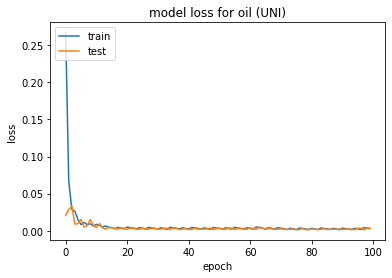

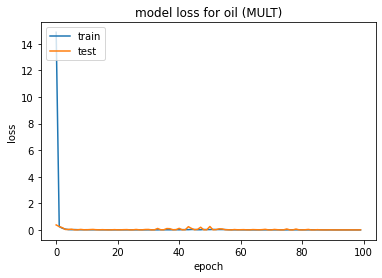

In [42]:
# OIL 
plt.plot(history_oil_uni.history['loss'])
plt.plot(history_oil_uni.history['val_loss'])
plt.title('model loss for oil (UNI)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_oil_mult.history['loss'])
plt.plot(history_oil_mult.history['val_loss'])
plt.title('model loss for oil (MULT)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

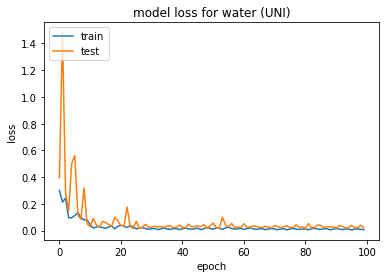

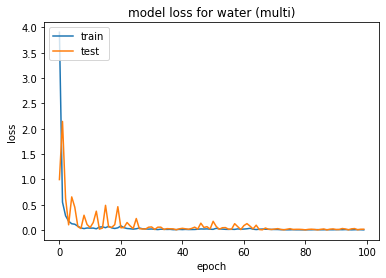

In [45]:
# WATER
plt.plot(history_water_uni.history['loss'])
plt.plot(history_water_uni.history['val_loss'])
plt.title('model loss for water (UNI)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_water_mult.history['loss'])
plt.plot(history_water_mult.history['val_loss'])
plt.title('model loss for water (multi)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

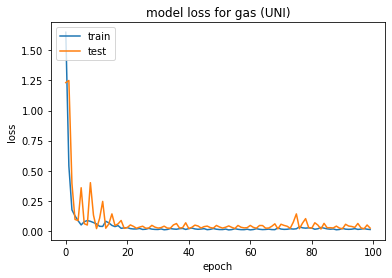

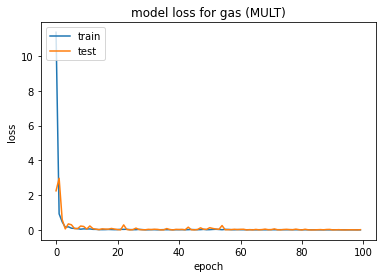

In [56]:
# GAS
plt.plot(history_gas_uni_well.history['loss'])
plt.plot(history_gas_uni_well.history['val_loss'])
plt.title('model loss for gas (UNI)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_gas_mult_well.history['loss'])
plt.plot(history_gas_mult_well.history['val_loss'])
plt.title('model loss for gas (MULT)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
## gas testing data set visualization
### univariate 
real_gas_uni_well = gas_uni_testY_well.flatten()
pred_gas_uni_well = model_gas_uni_well.predict(gas_uni_testX_well).flatten()
df_plot_gas_uni_well=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni_well, real_gas_uni_well]))))
df_plot_gas_uni_well['ds']=range(0,len(real_gas_uni_well))
### multivariate 
real_gas_mult_well = gas_mult_testY_well.flatten()
pred_gas_mult_well = model_gas_mult_well.predict(gas_mult_testX_well).flatten()
df_plot_gas_mult_well=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult_well, real_gas_mult_well]))))
df_plot_gas_mult_well['ds']=range(0,len(real_gas_mult_well))
## water 
## univariate
real_water_uni = water_uni_testY.flatten()
pred_water_uni = model_water_uni.predict(water_uni_testX).flatten()
df_plot_water_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([ pred_water_uni, real_water_uni]))))
df_plot_water_uni['ds']=range(0,len(real_water_uni))
## multivariate 
real_water_mult = water_mult_testY.flatten()
pred_water_mult = model_water_mult.predict(water_mult_testX).flatten()
df_plot_water_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([ pred_water_mult, real_water_mult]))))
df_plot_water_mult['ds']=range(0,len(real_water_mult))
## oil
## univariate
real_oil_uni = oil_uni_testY.flatten()
pred_oil_uni = model_oil_uni.predict(oil_uni_testX).flatten()
df_plot_oil_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_oil_uni, real_oil_uni]))))
df_plot_oil_uni['ds']=range(0,len(real_oil_uni))
## multivariate 
real_oil_mult = oil_mult_testY.flatten()
pred_oil_mult = model_oil_mult.predict(oil_mult_testX).flatten()
df_plot_oil_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_oil_mult, real_oil_mult]))))
df_plot_oil_mult['ds']=range(0,len(real_oil_mult))

In [63]:
pred_gas_mult_well.shape

(2095,)

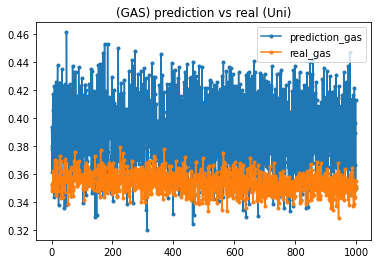

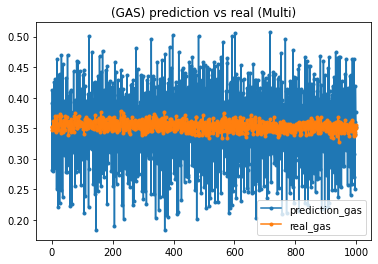

In [64]:
### GAS
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real (Uni)')
ax.plot(df_plot_gas_uni_well['ds'].iloc[start:end], df_plot_gas_uni_well['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_uni_well['ds'].iloc[start:end], df_plot_gas_uni_well['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real (Multi)')
ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()

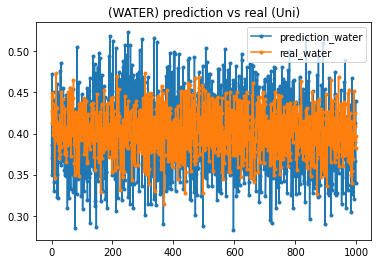

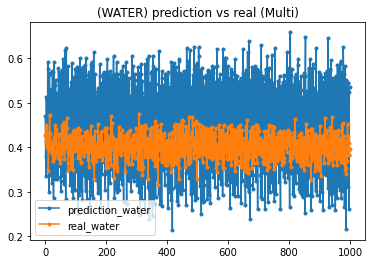

In [65]:
### WATER 
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(WATER) prediction vs real (Uni)')
ax.plot(df_plot_water_uni['ds'].iloc[start:end], df_plot_water_uni['prediction'].iloc[start:end], marker=".", label='prediction_water')
ax.plot(df_plot_water_uni['ds'].iloc[start:end], df_plot_water_uni['real'].iloc[start:end], marker=".", label='real_water')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(WATER) prediction vs real (Multi)')
ax.plot(df_plot_water_mult['ds'].iloc[start:end], df_plot_water_mult['prediction'].iloc[start:end], marker=".", label='prediction_water')
ax.plot(df_plot_water_mult['ds'].iloc[start:end], df_plot_water_mult['real'].iloc[start:end], marker=".", label='real_water')
ax.legend()

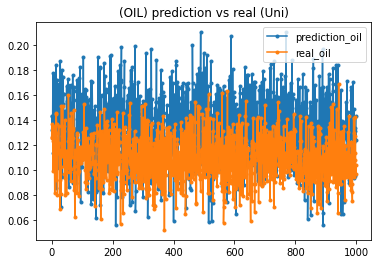

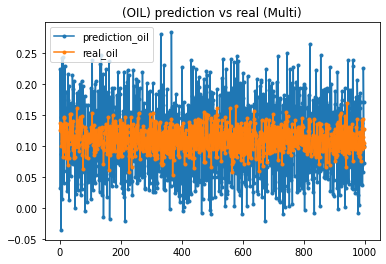

In [66]:
## OIL
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(OIL) prediction vs real (Uni)')
ax.plot(df_plot_oil_uni['ds'].iloc[start:end], df_plot_oil_uni['prediction'].iloc[start:end], marker=".", label='prediction_oil')
ax.plot(df_plot_oil_uni['ds'].iloc[start:end], df_plot_oil_uni['real'].iloc[start:end], marker=".", label='real_oil')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(OIL) prediction vs real (Multi)')
ax.plot(df_plot_oil_mult['ds'].iloc[start:end], df_plot_oil_mult['prediction'].iloc[start:end], marker=".", label='prediction_oil')
ax.plot(df_plot_oil_mult['ds'].iloc[start:end], df_plot_oil_mult['real'].iloc[start:end], marker=".", label='real_oil')
ax.legend()